In [1]:
import pandas as pd
import numpy as np

Dataset filename .csv decoding

e.g. **Faults_Cleaning_Counters_100_D_20_1.csv**

Field | Description
------|-----------------
Faults_Cleaning_Counters | what is in the datset
100 |  number of machines Serial Numbers in the datset. 
D | time period of summarization D=Days W=Weeks
10 | depth of each row in periods
1 | time periods between two consecutive rows for the same Serial Number

Read the dataset

In [2]:
dataset_root = "Faults_Cleaning_Counters_101_D_20_1"


In [3]:
df = pd.concat([pd.read_csv(dataset_root+"_00.csv",parse_dates = ['Target Timestamp']),
                pd.read_csv(dataset_root+"_01.csv",parse_dates = ['Target Timestamp']),
                pd.read_csv(dataset_root+"_02.csv",parse_dates = ['Target Timestamp']),
                pd.read_csv(dataset_root+"_03.csv",parse_dates = ['Target Timestamp'])])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45323 entries, 0 to 45322
Columns: 605 entries, Unnamed: 0 to CLEANING-1D
dtypes: datetime64[ns](1), float64(601), int64(2), object(1)
memory usage: 209.2+ MB


## Dataset rearranging

The dataset comes with the TARGET column being the number of faults in the target day. I can make the prediction more general (and more useful) builind a target as the occurrence of a fault in one of the last N days.

To keep the preprocessing general I get the information about the categories and the time period from the data itself

In [6]:
#List of root names of categories
#For each column name, get the ones with a '-' in the name, take the part of the names before the '-' and make it a set.
categories_roots = list(set([s.split('-')[0] for s in df.columns if '-' in s]))
print(categories_roots)

['numcaffegr3', 'numvaporeariats', 'ngr2', 'numvaporets', 'numcaffegenerale', 'numsolubile', 'ngr1', 'numcaffegr2', 'nummac1gr1', 'portatagr2', 'portatagr1', 'portatagr4', 'tempogr2', 'numcioccolato', 'FAULT', 'tempogr3', 'numlattegr1', 'numcaffegr1', 'portatagr3', 'tempogr1', 'nummac2gr1', 'numacqua', 'numlattefr', 'ngr3', 'ngr4', 'numcicligr1', 'tempogr4', 'numcaffegr4', 'numvapore', 'CLEANING']


In [7]:
#List of root names of categories
#For each column name, get the ones with a '-' in the name, take the part of the names After the '-' and make it a set.
time_period=list(set([s.split('-')[1][-1] for s in df.columns if '-' in s]))[0]
print(time_period)

D


Timestamp column is in pd.Timestamp type - transform it in a cardinal number starting from the first date of the dataset

In [8]:
df['Target Timestamp'].min()
df['Target day'] = (df['Target Timestamp']-df['Target Timestamp'].min()).apply(lambda d: d.days)

## Prediction width parameter

How many days to aggregate to build the TARGET

In [9]:
# Target of the prediction is the aggregation of N days
target_width = 5

In [10]:
columns_to_sum = ['FAULT-%d%s'%(n,time_period) for n in range(target_width-1,0,-1)]
columns_to_sum.append('TARGET')
columns_to_sum

['FAULT-4D', 'FAULT-3D', 'FAULT-2D', 'FAULT-1D', 'TARGET']

I have to drop the columns relevant to the period I want to predict - all type of columns, not just faults

In [11]:
from itertools import chain
columns_to_drop = [['%s-%d%s'%(root,n,time_period) for n in range(target_width-1,0,-1)] for root in categories_roots]
columns_to_drop = list(chain(*columns_to_drop))
#columns_to_drop


Build the new TARGET column

In [12]:

df['TARGET']=df[columns_to_sum].sum(axis=1)
# For now only boolean prediction
df['TARGET'] = (df['TARGET']>0).astype(int)


Check distribution of target values

In [13]:
df['TARGET'].value_counts()

0    23856
1    21467
Name: TARGET, dtype: int64

### Calendar informations

Adding information about week days involved in the target period: count of Week Days, Month and Year Week

In [14]:
def wdays_in_range(target,width = target_width):
    l = np.zeros(7)
    t0 = (target-pd.Timedelta(str(width)+'D')).weekday()
    for d in range(t0,t0+width):
        l[d%7]+=1
    return l


Build & concatenate the columns with count of week days included in the target period

In [15]:
tdays_df = pd.DataFrame([*df['Target Timestamp'].apply(wdays_in_range)],index=df.index,
                        columns=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
df = pd.concat([df,tdays_df],axis=1)

tdays_df.sample(5)

,Mon,Tue,Wed,Thu,Fri,Sat,Sun
1831,0.0,1.0,1.0,1.0,1.0,1.0,0.0
24158,1.0,1.0,0.0,0.0,1.0,1.0,1.0
42404,1.0,1.0,0.0,0.0,1.0,1.0,1.0
14462,1.0,1.0,1.0,1.0,0.0,0.0,1.0
34694,1.0,1.0,1.0,1.0,0.0,0.0,1.0


Month and Week columns

In [16]:
df['Month']=(df['Target Timestamp'].apply(lambda d: d.month)).astype('category')
df['Week']=(df['Target Timestamp'].apply(lambda d: d.week)).astype('category')

Remove unwanted columns either because part of the target days or because useless (Serial, Timestamp, Unnamed)

In [17]:
columns_to_drop.extend(['Unnamed: 0','Target Timestamp','Serial'])
df = df.drop(columns_to_drop,axis=1)

I remove also the Target day for more generality

In [18]:
df = df.drop('Target day',axis=1)

In [19]:
df.head()

,Model,TARGET,numcaffegenerale-20D,numcaffegenerale-19D,numcaffegenerale-18D,numcaffegenerale-17D,numcaffegenerale-16D,numcaffegenerale-15D,numcaffegenerale-14D,numcaffegenerale-13D,...,CLEANING-5D,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Month,Week
0,model 20,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,10,42
1,model 20,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,10,42
2,model 20,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,10,42
3,model 20,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,10,43
4,model 20,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,10,43


Make the "Model" column Categorical

In [20]:
df['Model'] = df['Model'].astype('category')

import Machine Learning stuff

In [21]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.ensemble import RandomForestClassifier

from datetime import datetime
import timeit

Light GBM classifier is used to allow eventually the uasge of Grid Search for params tuning

In [22]:

num_leaves  = 350
n_estimators   = 100
learning_rate  = 0.01
num_iterations = 100
verbose=True

X = df.drop('TARGET',axis=1)
y = df['TARGET'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

lgbmc = lgb.LGBMClassifier(num_leaves     = num_leaves,
                           n_estimators   = n_estimators,
                           learning_rate  = learning_rate,
                           num_iterations = num_iterations,
                           objective      = 'binary',
                           boosting_type  = 'gbdt' ,
                           is_unbalance   = True,
                           metric         = ['binary_logloss'])

start=timeit.default_timer()
lgbmc.fit(X_train,y_train,
               #categorical_feature =[0],
               feature_name = list(X.columns))
stop=timeit.default_timer()

prob_pred = lgbmc.predict(X_test)
predictions = (prob_pred > 0.5).astype(int)

cm = confusion_matrix(y_test,predictions)
f1 = f1_score(y_test,predictions)
if verbose:
    print("Fitting time: {} s".format(stop-start))
    print("Classification Report")
    print(classification_report(y_test,predictions))
    print("Confusion Matrix")
    print(cm)
    print('F1:',f1)

feature_importance = pd.DataFrame({'f_name':list(X.columns),'importance':lgbmc.feature_importances_}).dropna()
feature_importance = feature_importance[feature_importance['importance']>0].\
        sort_values('importance',ascending=False).set_index('f_name')['importance'][:30]

print(feature_importance) 

C:\Users\emamorc\AppData\Local\conda\conda\envs\lgbm\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fitting time: 25.623752487267904 s
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      7829
           1       0.83      0.86      0.85      7128

   micro avg       0.85      0.85      0.85     14957
   macro avg       0.85      0.85      0.85     14957
weighted avg       0.85      0.85      0.85     14957

Confusion Matrix
[[6616 1213]
 [ 999 6129]]
F1: 0.8471319972356598
f_name
Week                    979
FAULT-6D                577
FAULT-9D                503
FAULT-7D                485
FAULT-10D               456
FAULT-17D               434
FAULT-8D                433
FAULT-18D               427
FAULT-11D               419
Model                   382
numcaffegr1-5D          371
numcaffegenerale-5D     356
numcaffegenerale-6D     338
FAULT-19D               322
numcaffegenerale-20D    319
FAULT-20D               318
numcaffegenerale-17D    318
FAULT-14D               316
FAULT-5D                313
numcaffege

## Interpretation with SHAP

https://shap.readthedocs.io/en/latest/

![SHAP](https://shap.readthedocs.io/en/latest/_images/shap_diagram.png)

SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations (see the [SHAP NIPS Paper](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) for details).



In [23]:
import shap
shap.initjs()

[Source: **Hands-on Machine Learning Model Interpretation** by Dipanjan (DJ) Sarkar](https://towardsdatascience.com/explainable-artificial-intelligence-part-3-hands-on-machine-learning-model-interpretation-e8ebe5afc608)

This returns a matrix of SHAP values (# samples, # features). Each row sums to the difference between the model output for that sample and the expected value of the model output (which is stored as expected_value attribute of the explainer). Typically this difference helps us in explaining why the model is inclined on predicting a specific class outcome.

In [24]:
explainer = shap.TreeExplainer(lgbmc)
shap_values = explainer.shap_values(X_test)
print('Expected Value:', explainer.expected_value)


Expected Value: -0.1115999648026605


In [25]:
pd.DataFrame(shap_values).head()

,0,1,2,3,4,5,6,7,8,9,...,480,481,482,483,484,485,486,487,488,489
0,-0.066952,0.000585,0.000025,-0.000706,-0.000303,0.000162,0.000815,-0.000464,-0.001098,-0.002824,...,-0.000632,0.001365,0.000139,0.000420,-0.000663,-0.000360,-0.001134,0.000084,0.005004,0.016210
1,-0.200980,-0.001061,0.000956,-0.000173,-0.005329,0.000045,0.009927,0.004454,0.013321,0.003408,...,-0.001898,0.002593,-0.000258,0.000959,-0.001166,0.002440,0.000128,-0.000168,-0.006563,0.067686
2,0.122537,0.004778,-0.000441,-0.002682,-0.000807,-0.003893,-0.003865,-0.000959,-0.007767,-0.002174,...,-0.001628,-0.004013,-0.000652,-0.001548,-0.000425,-0.000833,-0.000411,-0.001234,-0.021200,-0.049283
3,0.048405,0.000513,0.000366,0.000414,0.000214,-0.001769,-0.001716,-0.000415,0.000403,-0.002698,...,-0.000535,-0.003461,0.000750,0.000280,-0.000295,-0.000242,-0.000836,-0.000322,0.000351,0.014957
4,-0.075503,-0.000705,-0.000900,0.000868,0.000380,0.000343,-0.000875,-0.000658,0.000208,0.001047,...,-0.010188,0.005027,0.000103,-0.002688,-0.000364,0.000170,-0.000734,0.000263,-0.000611,-0.056169


Exmplation of specific prediction (*pred_index* in the test set)

In [26]:
pred_index = 0

In [27]:
shap.force_plot(explainer.expected_value, 
                shap_values[pred_index,:], X_test.iloc[pred_index,:])

### Feature importance histogram

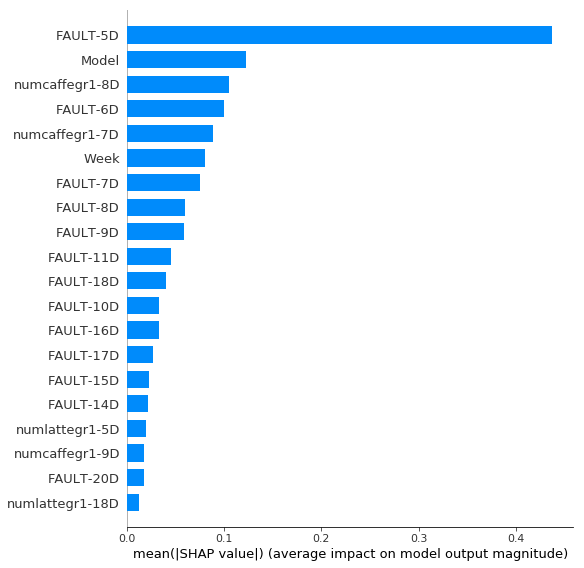

In [28]:
shap.summary_plot(shap_values, 
                  X_test, plot_type="bar")

### SHAP Summary Plot
Besides a typical feature importance bar chart, SHAP also enables us to use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. Note that when the scatter points don’t fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

[Source: **Hands-on Machine Learning Model Interpretation** by Dipanjan (DJ) Sarkar](https://towardsdatascience.com/explainable-artificial-intelligence-part-3-hands-on-machine-learning-model-interpretation-e8ebe5afc608)


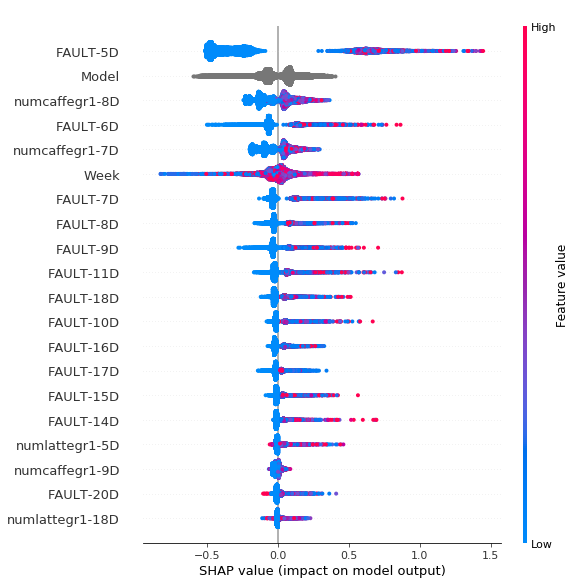

In [29]:
shap.summary_plot(shap_values, X_test)

Calendar features Month and Week score high in th relevance, but classification does not improve. Are thy correlated in some hidden way with other features? Or we have not enough years in the logs to validate?

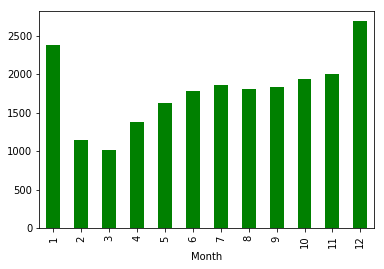

In [30]:
df.groupby('Month')['TARGET'].sum().plot(kind='bar',color='g')

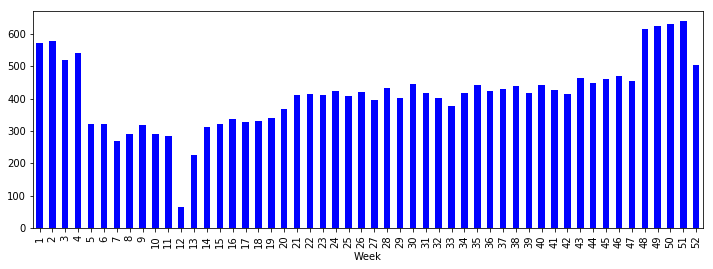

In [31]:
df.groupby('Week')['TARGET'].sum().plot(kind='bar',figsize=(12,4),color='b')

## Results summary for various TARGET widths